# Project

# Dependencies

***GPU***

---



In [0]:
#GPU
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
  
  
import torch
print(torch.__version__)
print("GPU is available" if torch.cuda.is_available() else "GPU is not available")

0.4.0
GPU is available


 ***Libraries***

---



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import pandas as pd
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from matplotlib.pyplot import imshow
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from torch.nn import functional as F
import torchvision.models as models

***PIL 4.1***

---



In [0]:
#Please install Pillow version 4.1.1 to run the code properly.
##############################################################
!pip install Pillow==4.1.1
##############################################################
import PIL
from PIL import Image

***Google Drive***

---



In [0]:
#get access to your google drive in colab using this code
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***PyDrive***

---



In [0]:
#The following code has been copied from:https://colab.research.google.com/drive/1P2AmVHPmDccstO0BiGu2uGAG0vTx444b
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive

# HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/file/d/1BkJ1ivubvpTeGfix-7eQt6KUGQPfJwdq/view?usp=sharing )
zip_id = '1BkJ1ivubvpTeGfix-7eQt6KUGQPfJwdq'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('train_corrected.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('train_corrected.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

Uncompressing zip file


# Explore Dataset

***Get Data***

---



In [0]:
# get data
data = pd.read_csv('MODEL/train_cars.csv')

***Get image name and labels***

---



In [0]:
X = data.iloc[:,0]
y = data.iloc[:,1]
print(len(X))
print(len(y))

11617
11617


***Look at the Data***

---




 Dataset 

################### Exploring Dataset:
data.describe() 
  count     11617
unique       15
top       sedan
freq       5783
Name: target, dtype: object
 
 Label Counts for each: 
  target
bus                                 53
cement mixer                        17
crane truck                         16
dedicated agricultural vehicle       5
hatchback                         3080
jeep                               865
light truck                        164
minibus                             25
minivan                            586
pickup                             435
prime mover                         44
sedan                             5783
tanker                               3
truck                              179
van                                362
Name: target, dtype: int64


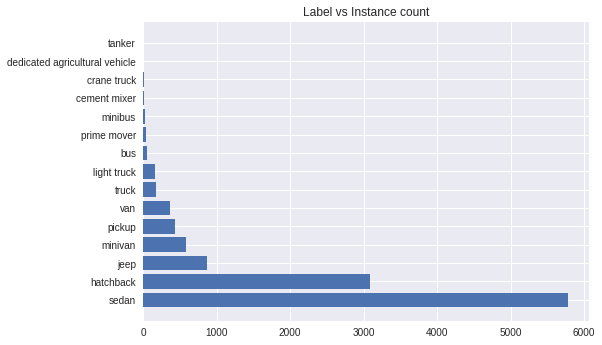

################### Finish Exploring Dataset ###################


In [0]:
#https://matplotlib.org/gallery/statistics/barchart_demo.html
#https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html
def explore_data(data):
  #describe our dataset
  print("################### Exploring Dataset:")
  print("data.describe() \n ", data.describe())

  #count the number of examples for each label
  print(" \n Label Counts for each: \n ", data.groupby(data).size())

  #make a dictionary for bar chart
  a = data.value_counts().to_dict()
  names = list(a.keys())
  values = list(a.values())

  #define the size our bar chart
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import figure
  figure(num=None)

  #tick_label does the some work as plt.xticks()
  plt.barh(range(len(a)),values,tick_label=names)
  plt.title("Label vs Instance count")
  plt.savefig('bar.png')
  plt.show()
  print("################### Finish Exploring Dataset ###################")

#overall_data
print("\n Dataset \n")
explore_data(y)


# Convert Labels to Indices

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
new_labels = le.fit(y)
y = le.transform(y)

In [0]:
le.classes_

array(['bus', 'cement mixer', 'crane truck',
       'dedicated agricultural vehicle', 'hatchback', 'jeep',
       'light truck', 'minibus', 'minivan', 'pickup', 'prime mover',
       'sedan', 'tanker', 'truck', 'van'], dtype=object)

# Split into train, valid and test

In [0]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.10, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    stratify=y_test, 
                                                    test_size=0.5, shuffle=True)


In [0]:
print(len(X_train),len(y_train))
print(len(X_valid),len(y_valid))
print(len(X_test),len(y_test))
print()

10455 10455
581 581
581 581



# Create Custom Dataset

In [0]:
class CompDataset(Dataset):
  
  #define the constructor
  def __init__(self, X, y, root_dir, transform=None):
    self.len = len(X)
    self.names = X
    self.root_dir = root_dir
    self.transform = transform
    self.label = y
    

  #define the mapping from label to image
  def __getitem__(self, index):
      img_name = os.path.join(self.root_dir, self.names.iloc[index])
      image = Image.open(img_name)
      #get image dimensions
      width, height = image.size
      #check if it's vertical or horizontal and rotate it
      if width > height:
        image = image.rotate(90)      
      label = self.label[index]

      #apply transformations
      if self.transform is not None:
        image = self.transform(image)
        
      return (image, label)
    
  #return the length    
  def __len__(self):
    return self.len

    
comp_dataset = CompDataset(X_train, y_train, root_dir='MODEL/train', transform=None)

***output check***

---



In [0]:
comp_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=27x58 at 0x7F1FA422D9B0>,
 4)

***Define Transformations***

---



In [0]:
#define the transformations to be applied on the image
data_transform_train = transforms.Compose([
        transforms.Resize((140,140)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.476, 0.498, 0.561), (0.250, 0.255, 0.263))
    ])
#define the transformations to be applied on the image
data_transform_valid = transforms.Compose([
        transforms.Resize((140,140)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.476, 0.498, 0.561), (0.250, 0.255, 0.263))

    ])

#define the transformations to be applied on the image
data_transform_test = transforms.Compose([
        transforms.Resize((140,140)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.476, 0.498, 0.56), (0.250, 0.255, 0.263))

    ])

***Apply transformations***

---



In [0]:
train_dataset = CompDataset(X_train, y_train, root_dir='MODEL/train', transform=data_transform_train)
test_dataset = CompDataset(X_test, y_test, root_dir='MODEL/train', transform=data_transform_test)
valid_dataset = CompDataset(X_valid , y_valid, root_dir='MODEL/train', transform=data_transform_valid)

***Find mean and std across three channels***

---



In [0]:
#initialise placeholders
mean_r=[]
mean_g=[]
mean_b=[]

std_r=[]
std_g=[]
std_b=[]


for i in range(comp_dataset.len):
  image, label= comp_dataset[i]
  image = np.array(image)
  #print(type(image))
  #print(image[:,:,0].reshape(-1))
  mean_r.append(image[:,:,0].reshape(-1))
  #print(len(mean_r))
  #np.mean
  mean_r.append(image[:,:,0].flatten())
  mean_g.append(image[:,:,1].flatten())
  mean_b.append(image[:,:,2].flatten())

  #np.std
  std_r.append(image[:,:,0].flatten())
  std_g.append(image[:,:,1].flatten())
  std_b.append(image[:,:,2].flatten())
  
  
r = np.mean(np.concatenate(mean_r).ravel())
g = np.mean(np.concatenate(mean_g).ravel())
b = np.mean(np.concatenate(mean_b).ravel())
r=r/255
g=g/255
b=b/255
print(r, g, b)

s_r = np.std(np.concatenate(std_r).ravel())
s_g = np.std(np.concatenate(std_g).ravel())
s_b = np.std(np.concatenate(std_b).ravel())
s_r=s_r/255
s_g=s_g/255
s_b=s_b/255
print(s_r, s_b, s_g)
#49.15164394405574 49.15164394405574 49.15164394405574
#0.19

0.4763334834131336 0.4981582784849688 0.5605659331207022
0.2508132191323234 0.2557287362490529 0.2636596483103132


# Initialise Dataloaders

In [0]:
#declare and initialize dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=32, num_workers=0, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                             batch_size=32, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=32, num_workers=0, shuffle=True)

In [0]:
print(len(train_loader.dataset))
print(len(validation_loader.dataset))
print(len(test_loader.dataset))

10455
581
581


***Display a batch from train_loader***

---



In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % le.classes_[labels[j]] for j in range(32)))

ValueError: ignored

sedan sedan sedan hatchback sedan hatchback sedan sedan sedan sedan minivan sedan sedan sedan sedan sedan sedan sedan sedan  jeep sedan sedan sedan sedan sedan sedan sedan sedan hatchback sedan crane truck  jeep


# ResNet-18

In [0]:
#reference:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# load pre-trained model
#####################################################
#download pretrained ResNet
import torchvision.models as models
model_res18 = models.resnet18(pretrained=True)
    
#get the number of input features of final layer
num = model_res18.fc.in_features

#update the input and output features of final layer
model_res18.fc = torch.nn.Linear(num, 15)
#model_res18.avgpool = torch.nn.MaxPool2d(2)
model_res18 = model_res18.cuda()

# Optimizer and Criterion

In [0]:
from torch import optim
optimizer = optim.Adam(model_res18.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training

The model does not exist. Please check the path provided in the line above!
[1,   100] loss: 1.273
[1,   200] loss: 1.081
[1,   300] loss: 1.027
[2,   100] loss: 0.987
[2,   200] loss: 0.951
[2,   300] loss: 0.938
[3,   100] loss: 0.896
[3,   200] loss: 0.898
[3,   300] loss: 0.877
[4,   100] loss: 0.839
[4,   200] loss: 0.850
[4,   300] loss: 0.857
[5,   100] loss: 0.838
[5,   200] loss: 0.806
[5,   300] loss: 0.831
[6,   100] loss: 0.783
[6,   200] loss: 0.740
[6,   300] loss: 0.798
[7,   100] loss: 0.718
[7,   200] loss: 0.767
[7,   300] loss: 0.762
[8,   100] loss: 0.734
[8,   200] loss: 0.707
[8,   300] loss: 0.729
[9,   100] loss: 0.691
[9,   200] loss: 0.715
[9,   300] loss: 0.708
[10,   100] loss: 0.665
[10,   200] loss: 0.665
[10,   300] loss: 0.662
[11,   100] loss: 0.624
[11,   200] loss: 0.674
[11,   300] loss: 0.653
[12,   100] loss: 0.602
[12,   200] loss: 0.586
[12,   300] loss: 0.611
[13,   100] loss: 0.567
[13,   200] loss: 0.572
[13,   300] loss: 0.605
[14,   100] los

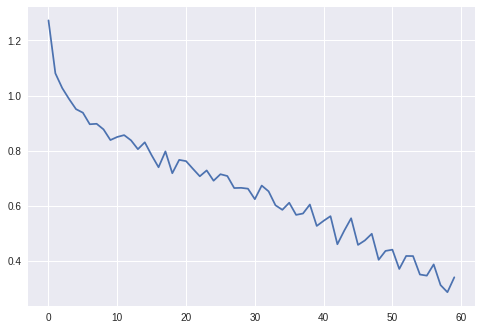

In [0]:
#reference:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#https://colab.research.google.com/drive/1qfgk854zE2xgaImq5bF8X2mROMIAE1_F
def train(epoch):
  model_res18.train()
  running_loss = 0.0
  r_loss=[]
  for batch_idx, (data,target) in enumerate(train_loader):
    data, target= data.cuda(), target.cuda()
    optimizer.zero_grad()
    output=model_res18(data)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_res18.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, 'drive/My Drive/Colab Notebooks/project_data/project_final_custom')
    # print statistics
    running_loss += loss.item()
    
    if batch_idx % 100 == 99:    # print every 100 mini-batches
        print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 100))
        r_loss.append(running_loss / 100)
        running_loss = 0.0
        
  return r_loss

#if model exists
if not os.path.exists('drive/My Drive/Colab Notebooks/project_data/project_final_custom'):
  print("The model does not exist. Please check the path provided in the line above!")
  #uncomment the following code to train the model.
  ###########################
  '''r_loss=[]
  for epoch in range(0, 20):
      r_loss.append(train(epoch))
  a = [item for sublist in r_loss for item in sublist]
  plt.plot(a)'''
  ###########################
else:
  #Load saved model
  checkpoint = torch.load('drive/My Drive/Colab Notebooks/project_data/project_final_custom')
  model_res18.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']

  model_res18.eval()
  # - or -
  #model.train()



    

***Accuracy***

---



Accuracy of the network on the train images: 91 %


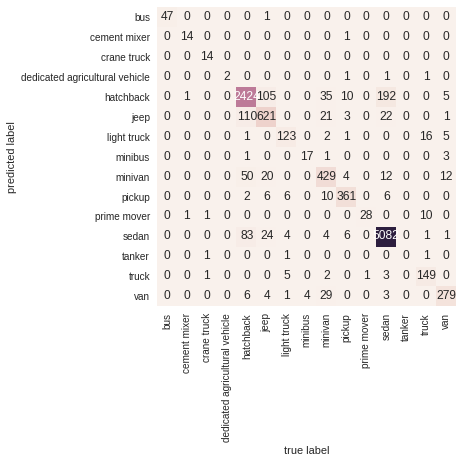

In [0]:
# content of this cell is copied from https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
correct = 0
total = 0
predictions = []
true_labels = []
model_res18.eval()
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model_res18(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(np.ravel(predicted.cpu().numpy()))
        true_labels.append(np.ravel(labels.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

def conf_matrix(true_labels, predictions):
  #heatmap of confusion matrix
  from sklearn.metrics import confusion_matrix
  import seaborn as sns; sns.set()
  conf_mat = confusion_matrix(predictions, true_labels)
  sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()
conf_matrix(true_labels, predictions)

# Validation

In [0]:
# content of this cell is copied from https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
correct = 0
total = 0
predictions = []
true_labels = []
model_res18.eval()
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model_res18(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(np.ravel(predicted.cpu().numpy()))
        true_labels.append(np.ravel(labels.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

def conf_matrix(true_labels, predictions):
  #heatmap of confusion matrix
  from sklearn.metrics import confusion_matrix
  import seaborn as sns; sns.set()
  conf_mat = confusion_matrix(predictions, true_labels)
  print(conf_mat)

conf_matrix(true_labels, predictions)

Accuracy of the network on the validation images: 71 %
[[  2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 103  23   2   0   7   5   0  23   0   2]
 [  0   0   0  13  14   1   0   4   4   0   6   0   0]
 [  0   0   0   1   0   4   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   6   3   0   0  12   4   0   0   0   7]
 [  0   0   0   1   1   1   0   0   8   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0  30   3   0   0   3   1   0 258   0   2]
 [  0   0   1   0   0   0   0   0   0   1   0   8   0]
 [  0   0   0   0   0   0   1   4   0   0   0   0   7]]


#Test

In [0]:
# content of this cell is copied from https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
correct = 0
total = 0
predictions = []
true_labels = []
model_res18.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model_res18(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(np.ravel(predicted.cpu().numpy()))
        true_labels.append(np.ravel(labels.cpu().numpy()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

def conf_matrix(true_labels, predictions):
  #heatmap of confusion matrix
  from sklearn.metrics import confusion_matrix
  import seaborn as sns; sns.set()
  conf_mat = confusion_matrix(predictions, true_labels)
  print(conf_mat)

conf_matrix(true_labels, predictions)

Accuracy of the network on the test images: 71 %
[[  2   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  94  13   0   0   6   3   0  23   0   1]
 [  0   1   0  16  21   1   0   3   1   0   5   0   0]
 [  0   0   0   1   0   3   0   0   1   0   2   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   8   3   0   0  13   1   0   0   0   4]
 [  0   0   0   2   0   1   0   0  10   0   4   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0  33   6   2   0   4   6   0 255   1   0]
 [  0   0   0   0   0   0   0   0   0   1   0   5   0]
 [  0   0   0   0   0   1   2   3   0   0   0   1  13]]
